# CSE327 Homework 5
**Due date: 23:59 on May 8, 2022 (Sunday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [35]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as T
from torchvision import models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op

from scipy import ndimage as nd 
import gc
gc.collect()

394

In [36]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
# Set your working directory (in your google drive) 
#   change it to your specific homework directory.
%cd 'gdrive/My Drive/CSE327/CSE327_HW5_Spring22'

[Errno 2] No such file or directory: 'gdrive/My Drive/CSE327/CSE327_HW5_Spring22'
/content/gdrive/My Drive/CSE327/CSE327_HW5_Spring22


In [38]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
import sys

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  return cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))

    #Random Rotation Augment:
    if(rotate_90):
      num_rot = len(data)
      min_angle = 0
      max_angle = 90
      rotated_imgs = []
      rotated_labels = labels[0:num_rot]
      print("90 Degree Rotation being applied to ", str(num_rot), " Images")
      print("Dataset Length Before Rotation: ", len(data))
      for i in range(num_rot):
        img = data[i]
        row_num, col_num = img.shape
        rand_angle = np.random.uniform(min_angle, max_angle)
        rot_mat = cv2.getRotationMatrix2D((col_num/2,row_num/2), rand_angle, 1) #prevent clipping
        img_rot = cv2.warpAffine(img,rot_mat,(col_num,row_num))
        rotated_imgs.append(img_rot)
      data.extend(rotated_imgs)
      labels.extend(rotated_labels)
      print("Dataset Length After Rotation: ", len(data))
    #
    # Write your Data Augmentation code here
    # mirroring
    # Left-Right vertical line flipping
    if(augment):
      num_flip = len(data) #flip them all, this can be changed for granular accuracy
      augmented_imgs = []
      augmented_labels = []
      print("Left-Right Flipping ", str(num_flip), " Images")
      print("Dataset Length Before Flipping: ", len(data))
      for i in range(len(data)):
        img = data[i]
        augmented_imgs.append(cv2.flip(img, 1))
        augmented_labels.append(labels[i])
      data.extend(augmented_imgs)
      labels.extend(augmented_labels)
      print("Dataset Length After Flipping: ", len(data))
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    # subtract data mean from img in data
    if(zero_centered):
      data_mean = np.mean(data, axis = 0)
      for i in range(len(data)):
        data[i] = data[i] - data_mean

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            #labels = np.asarray(labels).tolist()
            #print("Labels: ", labels[-1])
            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'LivingRoom', 1: 'Coast', 2: 'Bedroom', 3: 'Flower', 4: 'Kitchen', 5: 'Industrial', 6: 'Mountain', 7: 'Highway', 8: 'InsideCity', 9: 'Forest', 10: 'Store', 11: 'Street', 12: 'Office', 13: 'OpenCountry', 14: 'TallBuilding', 15: 'Suburb'} 


In [39]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=False , zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Left-Right Flipping  2400  Images
Dataset Length Before Flipping:  2400
Dataset Length After Flipping:  4800
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images 

Flower


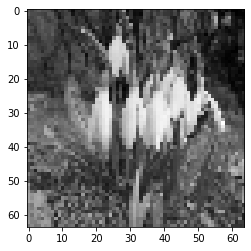

In [40]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) **you should be able to achieve around 50% test accuracy**. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [41]:
# ==========================================
#       Define Network Architecture
# ==========================================
class NeuralNetwork(nn.Module):
    def __init__(self, dropout, categories):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        #Sequential will operate commands in order given
        self.layer1 = nn.Sequential(
            #Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1), #input channel = 1 (img) , output channels = 32, kernel window = 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) 
        )
        self.layer2 = nn.Sequential(
            #Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) #underfitting vs overfitting right here
        )

        self.layer3 = nn.Sequential(
            #Layer 3
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout)
        )

        self.fc1 = nn.Linear(4 * 4 * 64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        #x = self.flatten(x)
        #logits = self.conv_relu_stack(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) #flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Clearly describe your method and accuracy increase/decrease for each of the three techniques.


In [42]:
# ==========================================
#         Optimize/Train Network
# ==========================================
def train(model, learn_rate, epochs, train_data):
  #Originally opted for Stochastic Gradient Descent, however convergence takes far longer, therefore opted for AdamW
  optimizer = op.AdamW(model.parameters(), lr=learn_rate) #additional params: betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False
  criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed. (Taken From Tutorial)
  train_cost = []
  train_accu = []
  train_size = len(train_data)
  print("Train Set Size: ", len(train_data))
  if torch.cuda.is_available(): #Use GPU if activated
    model = model.cuda()
    criterion = criterion.cuda()

  train_start_time = time.time()
  for epoch in range(epochs):
    for i, (X, Y) in enumerate(train_data):
      if torch.cuda.is_available():
            # Move to GPU
            X, Y = X.cuda(), Y.cuda() #WE can do this earlier?

      # Forward
      outputs = model(X)
      cost = criterion(outputs, Y)
      train_cost.append(cost.item())

      #initialize gradients and do backprop
      optimizer.zero_grad()
      cost.backward() # <= compute the gradient of the loss/cost function     
      optimizer.step() # <= Update the gradients
      
      _, predicted = torch.max(outputs.data, 1)
      acc = ((predicted.data == Y.data).float().mean()).item()
      train_accu.append(acc)


      if i != 0 and  i % (train_size - 1) == 0:
            print('Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%'
                    .format(epoch + 1, cost.item(), acc * 100))
  train_end_time = time.time()
  print("Training Took: ", train_end_time - train_start_time, "seconds")

In [43]:
#Training Parameters
learn_rate = 0.001
epochs = 20
dropout_prob = 0.5
categories = 16
model = NeuralNetwork(dropout=dropout_prob, categories=categories)
#model, learn_rate, epochs, train_data
train(model, learn_rate, epochs, trainloader_small)

Train Set Size:  96
Epoch 1, Loss: 2.3983, Accuracy: 18.00%
Epoch 2, Loss: 1.8921, Accuracy: 34.00%
Epoch 3, Loss: 1.9642, Accuracy: 42.00%
Epoch 4, Loss: 1.8808, Accuracy: 46.00%
Epoch 5, Loss: 1.4975, Accuracy: 44.00%
Epoch 6, Loss: 1.4546, Accuracy: 54.00%
Epoch 7, Loss: 1.4237, Accuracy: 64.00%
Epoch 8, Loss: 1.4142, Accuracy: 64.00%
Epoch 9, Loss: 1.3075, Accuracy: 66.00%
Epoch 10, Loss: 1.2581, Accuracy: 64.00%
Epoch 11, Loss: 1.2498, Accuracy: 60.00%
Epoch 12, Loss: 1.1749, Accuracy: 64.00%
Epoch 13, Loss: 1.1841, Accuracy: 68.00%
Epoch 14, Loss: 1.0327, Accuracy: 62.00%
Epoch 15, Loss: 0.9546, Accuracy: 74.00%
Epoch 16, Loss: 0.9479, Accuracy: 68.00%
Epoch 17, Loss: 0.9589, Accuracy: 68.00%
Epoch 18, Loss: 1.0509, Accuracy: 70.00%
Epoch 19, Loss: 1.0887, Accuracy: 64.00%
Epoch 20, Loss: 0.8638, Accuracy: 70.00%
Training Took:  40.27894473075867 seconds


#Description of Network Layout
The network is split into 3 grouped blocks (I called them layers [abstracted], for conceptualization) that contain actual network layers within them.

Data augmentation: Train Images are flipped horizantally to create 2400 extra images.

Data normalization: Zero Centered Train images by subtracting the mean of the image train set from all the images in the train set.

##First Abstracted Layer
Layer 1: [Convolution Layer]: [Input: 1, Output = 32, Kernel Size = 3, Padding = 1]

Layer 2: [Activation Layer (ReLU)]: [None]

Layer 3: [Pooling Layer]: [kernel_size=2, stride=2, padding=0]

Layer 4: [Dropout Layer]: [dropout=.5]

nn.Conv2d(32, 64, kernel_size=3, padding=1),

##Second Abstracted Layer
Layer 5: [Convolution Layer]: [Input: 32, Output = 64, Kernel Size = 3, Padding = 1]

Layer 6: [Activation Layer (ReLU)]: [None]

Layer 7: [Pooling Layer]: [kernel_size=2, stride=2, padding=0]

Layer 8: [Dropout Layer]: [dropout=.5]

##Third Abstracted Layer
Layer 9: [Convolution Layer]: [Input: 64, Output = 16, Kernel Size = 3, Padding = 1]

Layer 10: [Activation Layer (ReLU)]: [None]

Layer 11: [Pooling Layer]: [kernel_size=2, stride=2, padding=0]

Layer 12: [Dropout Layer]: [dropout=.5]

##Fully Connected Layers

Layer 13: [Linear Layer]: [Input: 1024, Output = 64]

Layer 14: [Linear Layer]: [Input: 64, Output = 32]

Layer 15: [Linear Layer]: [Input: 32, Output = 16]

#Performance

Accuracy: 60 - 64%

Train Time: 40-50 Seconds 


In [44]:
# ==========================================
#            Evaluating Network
# ==========================================

# Test the model
def test(model, test_images):
  since = time.time()
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_images:
          if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))
  
  elapsed = time.time() - since
  print('Test time elapsed in seconds: ', elapsed)

In [45]:
test(model, testloader_small)

Test Accuracy of the model on test images: 61.75000000000001 %
Test time elapsed in seconds:  0.04192304611206055


## Part2
List each of the techniques you used and the performances after using these techniques
<br> Please clearly indicate the techniques you use in the text blocks

In [46]:
# ==========================================
#       Technique1
# ==========================================
#Using Sigmoid Activation Function
class NeuralNetworkSigmoid(nn.Module):
    def __init__(self, dropout, categories):
        super(NeuralNetworkSigmoid, self).__init__()
        self.flatten = nn.Flatten()
        #Sequential will operate commands in order given
        self.layer1 = nn.Sequential(
            #Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1), #input channel = 1 (img) , output channels = 32, kernel window = 3
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) 
        )

        self.layer2 = nn.Sequential(
            #Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) #underfitting vs overfitting right here
        )

        self.layer3 = nn.Sequential(
            #Layer 3
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout)
        )

        self.fc1 = nn.Linear(4 * 4 * 64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        #x = self.flatten(x)
        #logits = self.conv_relu_stack(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) #flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [47]:
sigm_model = NeuralNetworkSigmoid(dropout=dropout_prob, categories=categories)
train(sigm_model, learn_rate, epochs, trainloader_small)

Train Set Size:  96
Epoch 1, Loss: 2.7800, Accuracy: 4.00%
Epoch 2, Loss: 2.7782, Accuracy: 8.00%
Epoch 3, Loss: 2.7762, Accuracy: 8.00%
Epoch 4, Loss: 2.7117, Accuracy: 10.00%
Epoch 5, Loss: 2.3931, Accuracy: 32.00%
Epoch 6, Loss: 2.2984, Accuracy: 32.00%
Epoch 7, Loss: 2.3097, Accuracy: 28.00%
Epoch 8, Loss: 2.1432, Accuracy: 34.00%
Epoch 9, Loss: 1.9799, Accuracy: 36.00%
Epoch 10, Loss: 1.9595, Accuracy: 36.00%
Epoch 11, Loss: 1.9749, Accuracy: 38.00%
Epoch 12, Loss: 1.7939, Accuracy: 40.00%
Epoch 13, Loss: 1.8160, Accuracy: 44.00%
Epoch 14, Loss: 1.8900, Accuracy: 42.00%
Epoch 15, Loss: 1.7963, Accuracy: 36.00%
Epoch 16, Loss: 1.7510, Accuracy: 46.00%
Epoch 17, Loss: 1.5805, Accuracy: 56.00%
Epoch 18, Loss: 1.9678, Accuracy: 40.00%
Epoch 19, Loss: 1.7186, Accuracy: 46.00%
Epoch 20, Loss: 1.7862, Accuracy: 44.00%
Training Took:  39.93567180633545 seconds


In [48]:
test(sigm_model, testloader_small)

Test Accuracy of the model on test images: 37.0 %
Test time elapsed in seconds:  0.042665719985961914


In [49]:
# ==========================================
#       Technique2
# ==========================================
#Atificially Increasing Train Data by Rotation [0-90] Degrees

# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small_rand_rot = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=True , zero_centered=True))
train_num_rot = len(trainloader_small_rand_rot)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num_rot, batch_num))

model_v_rot = NeuralNetwork(dropout=dropout_prob, categories=categories)
train(model_v_rot, learn_rate, epochs, trainloader_small_rand_rot)
test(model_v_rot, testloader_small)

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
90 Degree Rotation being applied to  2400  Images
Dataset Length Before Rotation:  2400
Dataset Length After Rotation:  4800
Left-Right Flipping  4800  Images
Dataset Length Before Flipping:  4800
Dataset Length After Flipping:  9600
Finish loading 192 minibatches(=50) of training samples.
Train Set Size:  192
Epoch 1, Loss: 2.3064, Accuracy: 26.00%
Epoch 2, Loss: 2.1786, Accuracy: 34.00%
Epoch 3, Loss: 2.0567, Accuracy: 42.00%
Epoch 4, Loss: 1.8862, Accuracy: 46.00%
Epoch 5, Loss: 1.9277, Accuracy: 38.00%
Epoch 6, Loss: 2.1

In [50]:
# ==========================================
#       Technique3
# ==========================================
#Change Model Architecture by Adding An Extra Layer
class NeuralNetworkExtraLayer(nn.Module):
    def __init__(self, dropout, categories):
        super(NeuralNetworkExtraLayer, self).__init__()
        self.flatten = nn.Flatten()
        #Sequential will operate commands in order given
        self.layer1 = nn.Sequential(
            #Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1), #input channel = 1 (img) , output channels = 32, kernel window = 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) 
        )
        self.layer2 = nn.Sequential(
            #Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout) #underfitting vs overfitting right here
        )

        self.layer3 = nn.Sequential(
            #Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            nn.Dropout(dropout)
        )
        
        self.layer4 = nn.Sequential(
            #Layer 4
            nn.Conv2d(128, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #Shrink Matrix by Half
            #nn.Dropout(dropout)
        )
        

        self.fc1 = nn.Linear(16 * 16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)

    def forward(self, x):
        #x = self.flatten(x)
        #logits = self.conv_relu_stack(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) #flatten #total size = 128 * 16
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [51]:
model_extra_layer = NeuralNetworkExtraLayer(dropout=dropout_prob, categories=categories)
train(model_extra_layer, learn_rate, epochs, trainloader_small)
test(model_extra_layer, testloader_small)

Train Set Size:  96
Epoch 1, Loss: 2.4403, Accuracy: 26.00%
Epoch 2, Loss: 2.1755, Accuracy: 32.00%
Epoch 3, Loss: 2.0637, Accuracy: 36.00%
Epoch 4, Loss: 1.8144, Accuracy: 40.00%
Epoch 5, Loss: 1.6626, Accuracy: 46.00%
Epoch 6, Loss: 1.7264, Accuracy: 48.00%
Epoch 7, Loss: 1.4925, Accuracy: 60.00%
Epoch 8, Loss: 1.4440, Accuracy: 58.00%
Epoch 9, Loss: 1.3879, Accuracy: 64.00%
Epoch 10, Loss: 1.0922, Accuracy: 62.00%
Epoch 11, Loss: 1.1086, Accuracy: 66.00%
Epoch 12, Loss: 1.3394, Accuracy: 62.00%
Epoch 13, Loss: 1.3208, Accuracy: 66.00%
Epoch 14, Loss: 0.9461, Accuracy: 76.00%
Epoch 15, Loss: 1.1019, Accuracy: 66.00%
Epoch 16, Loss: 0.8337, Accuracy: 76.00%
Epoch 17, Loss: 0.8625, Accuracy: 72.00%
Epoch 18, Loss: 0.8972, Accuracy: 72.00%
Epoch 19, Loss: 0.8017, Accuracy: 74.00%
Epoch 20, Loss: 0.6893, Accuracy: 78.00%
Training Took:  50.39322900772095 seconds
Test Accuracy of the model on test images: 59.75 %
Test time elapsed in seconds:  0.051189422607421875


#Techniques 

#1: Sigmoid Activation Function
Instead of using the ReLU activation function used in the original network architecture, I opted to try Sigmoid as the core activation function. Using Sigmoid caused a significant drop in the accuracy for tests by almost 25%.

Model Accuracy: 

Test Accuracy of the model on test images: 35 ~ 42 %

Test time elapsed in seconds:  0.04253530502319336

Significantly worse than Base Model.

#2: Artificially Increasing Train Data by Rotation [0-90] Degrees
Since we have a limited trainset data to train the model, I added an extra modification that rotates the entire trainset at random degrees in the interval 0-90 degrees. During rotation, images retain their original pixel intensities without the black edges that are common with rotation. This allowed for a slight improvement of about 1%

Test Accuracy of the model on test images: 62.0 ~ 63%

Test time elapsed in seconds:  0.04337787628173828

Slightly Better Performance than Base Model.

#3: Change Model Architecture by Adding An Extra Layer

Models sometimes underfit data due to shallow connections, therefore I attempted to add an extra layer to the base model architecture. The extra layer follows the same pattern as the other layers, that is a convolution layer followed by the ReLU activation function and a pooling layer to lower dimensionality. 

Test Accuracy of the model on test images: 60 ~ 62%

Test time elapsed in seconds:  0.050965309143066406

About the same Performance (or less) than Base Model.

# Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [52]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Fini

In [53]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
#IMPLEMENTING STRATEGY B OF REPLACING FINAL LAYER HERE:
alexnet = models.alexnet(pretrained=True)
print(alexnet) #last layers takes in 4096, outputs 1000, adapt to our number of categories:
alexnet.classifier[6] = nn.Linear(4096, 16)
learn_rate_alexnet = .0001
train(alexnet, learn_rate_alexnet, epochs, trainloader_large) #Accuracy ~ 85%
test(alexnet, testloader_large)

#AlexNet Alt CONSITENTLY reaching 85-87%
alexnet_alt = models.alexnet(pretrained = True)
alexnet_alt.classifier[6] = nn.Linear(4096, 1024); #fc1
alexnet_alt.classifier.append(nn.Mish()); #After reading an article about activation functions, this one seems to be best adapted to our usecase
alexnet_alt.classifier.append(nn.Dropout(.5));
alexnet_alt.classifier.append(nn.Linear(1024, 16));
train(alexnet_alt, learn_rate_alexnet, epochs, trainloader_large)
test(alexnet_alt, testloader_large)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [54]:
# ==========================================
#       Strategy A Implementation
# ==========================================
# Implementing Strategy A with One Vs All SVM
alexnet_svm = models.alexnet(pretrained=True)
#Keep last weights
for param in alexnet_svm.parameters():
    param.requires_grad = False
#We will get features by introducing and registering a hook in the layer sequence 
features = {}
def get_features(index_name):
    def hook(model, input, output):
        features[index_name] = output.detach()
    return hook

#Extract Features
def extract_feats(model, layer_num, total_features, loader):
  predict_main = []
  features_main = []
  output_features = []
  gc.collect()
  #Registering Hook at Second to Last Linear (Fully Connected) Layer
  model.classifier[layer_num].register_forward_hook(get_features('feature_list'))
  #FEATURE EXTRACTION LOOP
  for i, (images, labels) in enumerate(loader):
    outputs=(model(images))
    for index, output in enumerate(outputs):
      # print(output[:num_features].cpu().detach().numpy())
      output_features.append(np.array(output[:total_features].cpu().detach().numpy()))
      features_main.append(features['feature_list'][:total_features].cpu().detach().numpy())
      predict_main.append(labels[index].cpu().detach().numpy())

  return np.array(features_main), np.array(predict_main), np.array(output_features)

model = alexnet_svm
layer_num = 4 #second to last fully connected layer
total_features = 650 #total number of features we will sample per image batch
loader = trainloader_large 
start_time = time.time()
X_train, Y_train, X_Alt = extract_feats(model=model, layer_num=layer_num, total_features=total_features, loader=loader)
end_time = time.time()

print("Feature Extraction Train Time: ", end_time - start_time, "seconds")
print("X_train size: ", len(X_train), " Y_train Size: ", len(Y_train))
loader = testloader_large
start_time = time.time()
X_test, Y_test, X_Test_Alt = extract_feats(model=model, layer_num=layer_num, total_features=total_features, loader=loader)
end_time = time.time()
print("Feature Extraction Test Time: ", end_time - start_time, "seconds")
print("X_test size: ", len(X_test), " Y_test Size: ", len(Y_test))


Feature Extraction Train Time:  66.75423741340637 seconds
X_train size:  2400  Y_train Size:  2400
Feature Extraction Test Time:  11.369993209838867 seconds
X_test size:  400  Y_test Size:  400


In [55]:
# ==========================================
#  Training one-vs-all
# ==========================================
import gc
import sklearn.multiclass as mc
from sklearn import svm
from sklearn.metrics import accuracy_score
def onevsall_model(train_hists, train_labels, test_hists, test_labels, lambda_val):
  clf = mc.OneVsRestClassifier(svm.SVC(C=lambda_val , kernel='linear', probability=True, random_state=42)) #ignored , random_state
  clf.fit(train_hists, train_labels)
  pred = clf.predict(np.asarray(test_hists)) 
  return pred

gc.collect()
lbda = .0015
one_v_all_time_start = time.time()
pred = onevsall_model(X_Alt, Y_train, X_Test_Alt, Y_test, lbda)
acc = accuracy_score(Y_test, pred)
print("One vs All Accuracy Score: ", acc*100, "%");
print("One vs All Train Time: ", time.time() - one_v_all_time_start, "seconds")

One vs All Accuracy Score:  81.5 %
One vs All Train Time:  13.720258235931396 seconds


In [56]:
#BONUS VGG COMPARISON USING STRATEGY B OF REPLACING FINAL LAYER HERE:
vgg = models.vgg16(pretrained=True)
print(vgg) #last layers takes in 4096, outputs 1000, adapt to our number of categories:
vgg.classifier[6] = nn.Linear(4096, 16)

#using same alexnet parameters
train(vgg, learn_rate_alexnet, epochs, trainloader_large) 
test(vgg, testloader_large)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#Fine Tuning Last Layer (Strategy B)
In the first alexnet model, I changed only the last layer which originally was a 4096 input to 1000 output channel Linear layer. I changed it to 4096 -> 16. This worked fairly well with consistent results in an error range of +/- 1%

Accuracy: 85-86% , +/- 1% error range

Time: 

~100 - 115 seconds Training

< 1 seconds Testing

#Adding New Layers/Architecture (Extension on Strategy B)

Accuracy: 85-87% , +/- 1% error range

Time: 

~110 - 125 seconds Training

< 1 seconds Testing

In this second alexnet model (alexnet_alt) , I changed the last linear layer from 4096 -> 1000 to 4096->1024. I then added an activation function (Orginally I opted for ReLU to keep consistent with the rest of the model, however after reading a couple papers, I found that the Mish() activation function works better on average than ReLU for our usecase. I then added a dropout layer as I added an extra fully connected layer at the end. I did this to prevent overfitting in the model with the new added layer. Finally I added the last Linear layer of 1024 -> 16 output channels.


#Fine Tuning (Strategy A): One Vs All SVM on Features Training

I used two forms of obtaining features from the Alexnet model. The first was adding a hook function that would be run in the sequential order of the alexnet model. This hook function simply adds the current features to a list. The second method was to retrive features as I trained the alexnet model in batches, a much more simpler approach that worked better in the end. 

I specifically chose 650 as the number of features to obtain per batch, this is primarily to increase the end accuracy of the One vs All svm model. I experimented with the Lambda rate for the SVM and found that ~.0016 produced the best results.

Using One Vs All linear svc proved to be slightly better if enough feature points are sampled, for this project, I opted for 650 feature points as the minimum number of features to be able to match Strategy B.

Accuracy: ~81 - 84%

Alexnet Model Training (For Feature Extraction with Train Loader): 70 - 80 seconds

Alexnet Model Training (For Feature Extraction with Test Loader): 10 - 20 seconds

SVM Model Training: 10 - 20 seconds



##BONUS
VGG Bonus: Similar to the alexnet model, I replaced the last layer only for valid side by side comparisons.

VGG did almost 5-6% better than Alexnet, however took far longer to complete training.

Accuracy: 90-93%

Time: 1000 - 2000 seconds

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw5.zip" for homework5 in this structure:
```
Jordan_Michael_111134567_hw5
        |---Jordan_Michael_111134567_hw5.ipynb
        |---Jordan_Michael_111134567_hw5.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter ***the TA's email***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

## Attention on HW submission
---
Based on the issues we observed during HW1 grading, we would like to ***stress*** the following.

* Submit the ***zip file*** containing (a notebook, pdf of sharable link, results) on Blackboard, ***not only*** the pdf with link.

* Link in the pdf should be directed to the ***folder*** on Google Drive, not the notebook alone.

* ***DO NOT*** change the structure of the notebook. If you need additional codes, just add new cells. ***DO NOT*** delete existing cells.

* Notebook should run without errors by by clicking ***'run all'*** . Verify this before submission. Because we need to run all your notebooks for grading. (Your folder structure, paths on Google Drive should be correct. If you do your HW locally on Jupyter and upload later to Google Drive, ***run and verify*** this on Colab to avoid any ***PENALTY***.)

* ***DO NOT*** remove the outputs visualized in the notebook. We check both the codes and the outputs.

* Make sure you submit the notebook in which you coded your answers.

* Read the questions ***carefully***, as they may contain sub parts or even hints.

* Share your notebook with ***EDIT ACCESS*** to ***the TA***: ***sounak.mondal@stonybrook.edu***. Uncheck the Notify people box.

If you don’t follow these instructions you will be penalized and the grading will be significantly delayed.



<!--Write your report here in markdown or html-->
